In [11]:
# data from file
import shutil
shutil.unpack_archive('/content/Aquarium Combined.v2-raw-1024.coco.zip')

In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, csv file I/O
import matplotlib.pyplot as plt
import os
import torch
import torchvision
from torchvision import datasets, models, transforms as T
from  torchvision.transforms import functional as FT
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, sampler, random_split
import math
import copy
from PIL import Image
import cv2
import albumentations as A # data aug lib
%matplotlib inline

In [13]:
# remove warnings (optional)
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [14]:
print(torch.__version__)
print(torchvision.__version__)

2.4.0+cu121
0.19.0+cu121


# steps
Dataset prep/data preprocessing (obj detect)

Connect data, check lables, visualization

Create model/pretrain model

Optimize, loss fun

Training, eval, prediction

In [15]:
# our dataset is in cocoformat, we will need pypcoco tools
!pip install pycocotools
from pycocotools.coco import COCO

In [16]:
from albumentations.pytorch import ToTensorV2

In [17]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [9]:
# dataset preparation
class AquariumDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))

        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)

        image = transformed['image']
        boxes = transformed['bboxes']

        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.tensor(new_boxes, dtype=torch.float32)

        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images

    def __len__(self):
        return len(self.ids)

In [18]:
dataset_path = "/content"

#load classes
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

classes = [i[1]['name'] for i in categories.items()]
classes

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


['creatures',
 'fish',
 'jellyfish',
 'penguin',
 'puffin',
 'shark',
 'starfish',
 'stingray']

In [19]:
#create object of dataset class

train_dataset = AquariumDetection(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


447

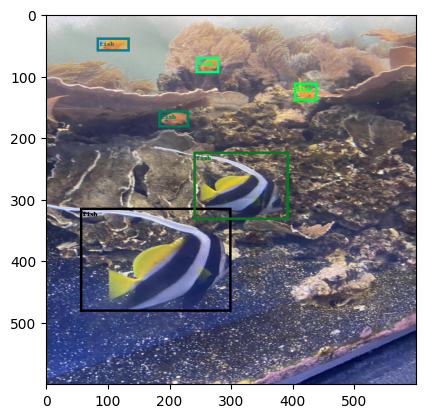

In [20]:
#This is a sample image and its bounding boxes, this code does not get the model's output

# Lets view a sample
sample = train_dataset[3]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

len(train_dataset)

In [21]:
# lets load the faster rcnn model
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) # just make sure this runs without error


device = torch.device("cuda") # use GPU to train
model = model.to(device)


Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:01<00:00, 76.3MB/s]


In [22]:
# Now, and optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)

In [23]:
def train_one_epoch(model, optimizer, loader, epoch):
    model.to(device)
    model.train()

    all_losses = []
    all_losses_dict = []


    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]


        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()


        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)


        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)


        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [24]:
# start training
num_epochs=10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader,epoch)

100%|██████████| 112/112 [00:23<00:00,  4.81it/s]


Epoch 0, lr: 0.010000, loss: 0.992133, loss_classifier: 0.461169, loss_box: 0.384083, loss_rpn_box: 0.035465, loss_object: 0.111415


100%|██████████| 112/112 [00:22<00:00,  4.96it/s]


Epoch 1, lr: 0.010000, loss: 0.784244, loss_classifier: 0.355247, loss_box: 0.334006, loss_rpn_box: 0.029665, loss_object: 0.065326


100%|██████████| 112/112 [00:20<00:00,  5.43it/s]


Epoch 2, lr: 0.010000, loss: 0.728414, loss_classifier: 0.309580, loss_box: 0.340676, loss_rpn_box: 0.026672, loss_object: 0.051486


100%|██████████| 112/112 [00:20<00:00,  5.46it/s]


Epoch 3, lr: 0.010000, loss: 0.680549, loss_classifier: 0.275501, loss_box: 0.335622, loss_rpn_box: 0.025573, loss_object: 0.043853


100%|██████████| 112/112 [00:19<00:00,  5.64it/s]


Epoch 4, lr: 0.010000, loss: 0.653853, loss_classifier: 0.254799, loss_box: 0.334885, loss_rpn_box: 0.024000, loss_object: 0.040169


100%|██████████| 112/112 [00:19<00:00,  5.66it/s]


Epoch 5, lr: 0.010000, loss: 0.650590, loss_classifier: 0.244358, loss_box: 0.348244, loss_rpn_box: 0.023454, loss_object: 0.034534


100%|██████████| 112/112 [00:21<00:00,  5.12it/s]


Epoch 6, lr: 0.010000, loss: 0.628821, loss_classifier: 0.239037, loss_box: 0.335201, loss_rpn_box: 0.022899, loss_object: 0.031683


100%|██████████| 112/112 [00:20<00:00,  5.39it/s]


Epoch 7, lr: 0.010000, loss: 0.648824, loss_classifier: 0.241458, loss_box: 0.355660, loss_rpn_box: 0.021860, loss_object: 0.029845


100%|██████████| 112/112 [00:18<00:00,  5.91it/s]


Epoch 8, lr: 0.010000, loss: 0.619366, loss_classifier: 0.228739, loss_box: 0.341939, loss_rpn_box: 0.021367, loss_object: 0.027321


100%|██████████| 112/112 [00:19<00:00,  5.72it/s]

Epoch 9, lr: 0.010000, loss: 0.616028, loss_classifier: 0.234157, loss_box: 0.333394, loss_rpn_box: 0.020907, loss_object: 0.027569


In [25]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

In [29]:
# Validation

valid_dataset = AquariumDetection(root=dataset_path, split="valid", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [30]:
# predict for valid image
img, _ = valid_dataset[5]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

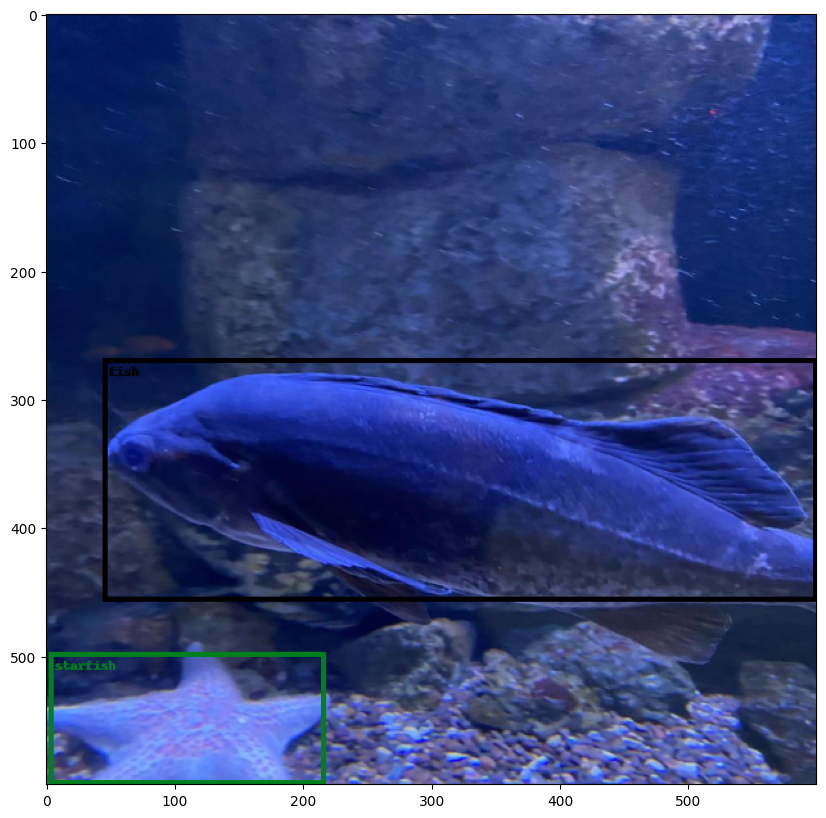

In [31]:
# visualization for test image
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))

In [26]:
# testing

test_dataset = AquariumDetection(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [27]:
# predict for test image
img, _ = test_dataset[5]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

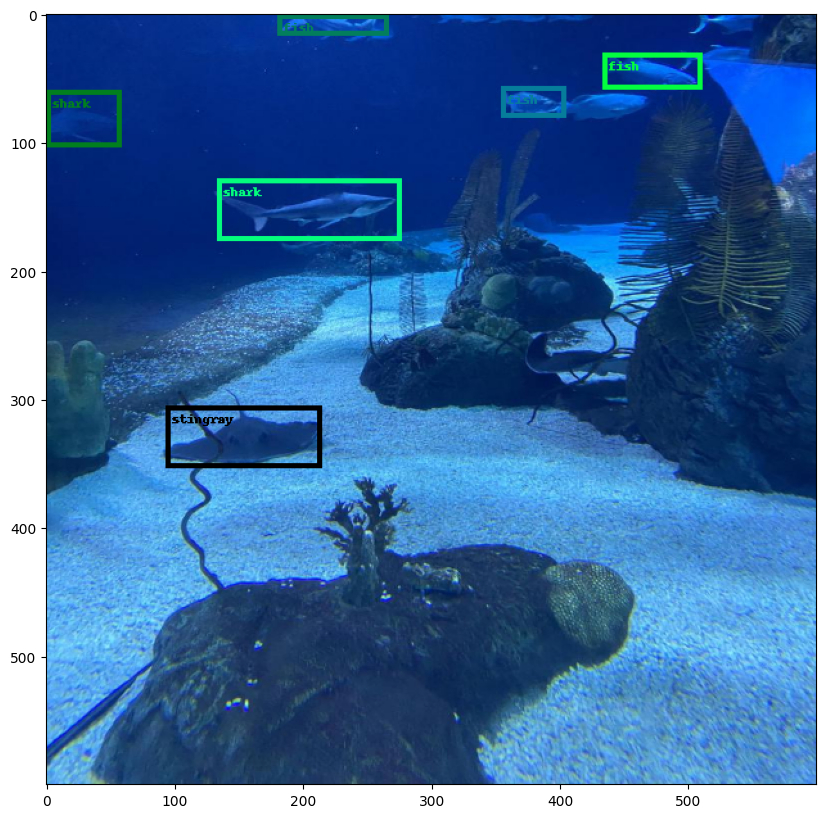

In [28]:
# visualization for test image
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))